## Link do Github : <https://github.com/BIRDRED/ProjetoKobe>

# Imports

In [58]:
import os
import warnings
import sys

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn import linear_model, preprocessing, metrics, model_selection
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from pycaret.classification import *
import pycaret.classification as pc
from pandas import Series, DataFrame

import seaborn as sn

if 'inline_rc' not in dir():
    inline_rc = dict(mpl.rcParams)

SEED = 10
np.random.seed(SEED)

In [2]:
mpl.rcParams.update(inline_rc)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
mpl.rc('font', **font)
lines = {'linewidth' : 3}
mpl.rc('lines', **lines)

In [3]:
registered_model_name = 'modelo_projeto_kobe'
min_precision = 0.7
model_version = -1 # recuperar a ultima versao
nexamples = 4

# Diagrama do Pipeline do Projeto

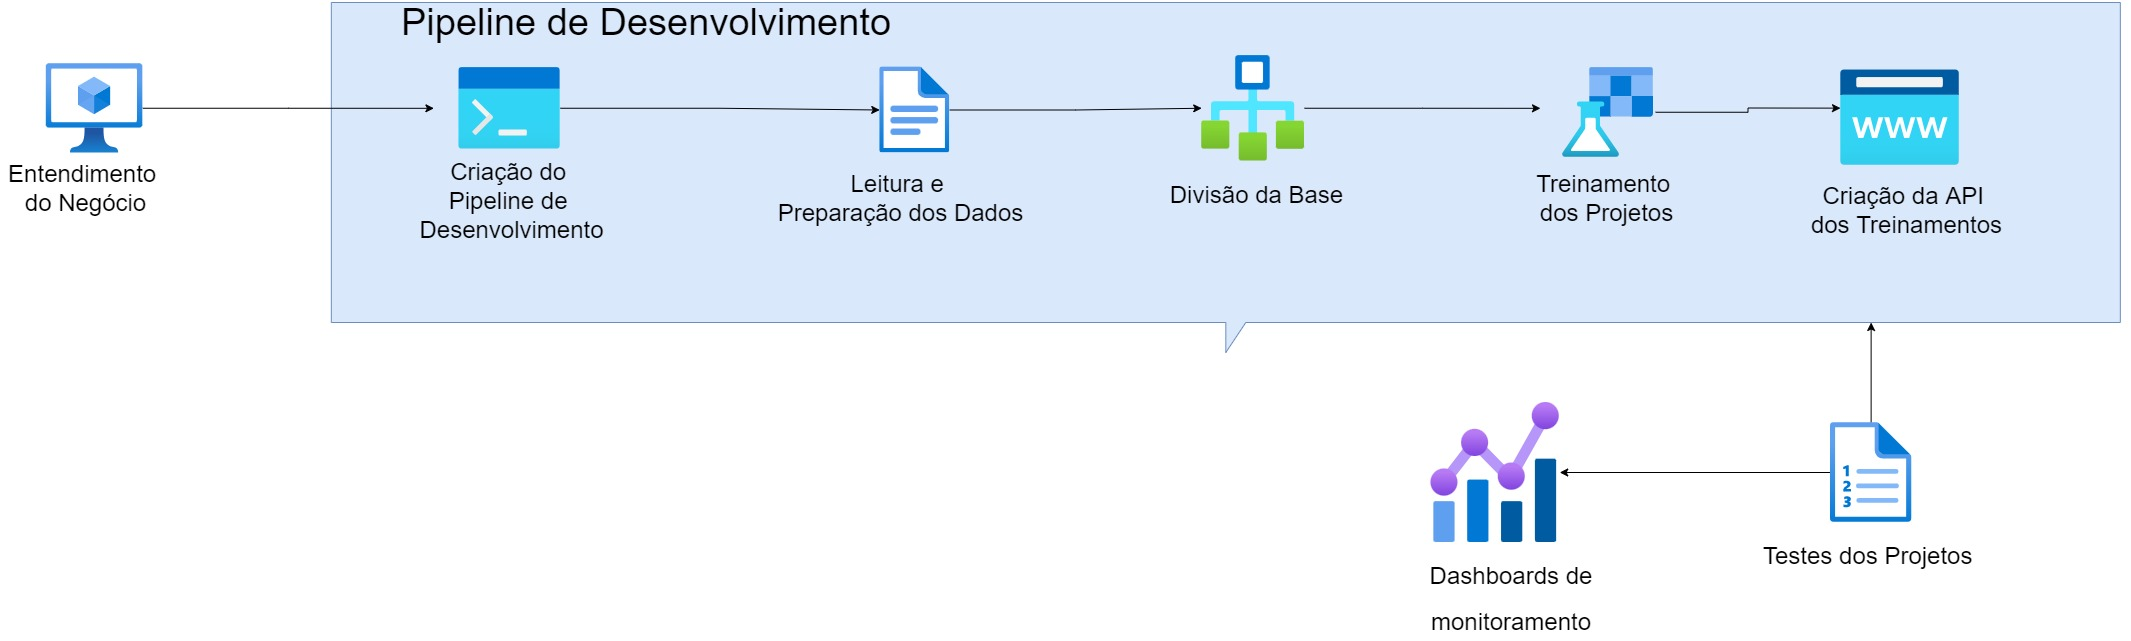

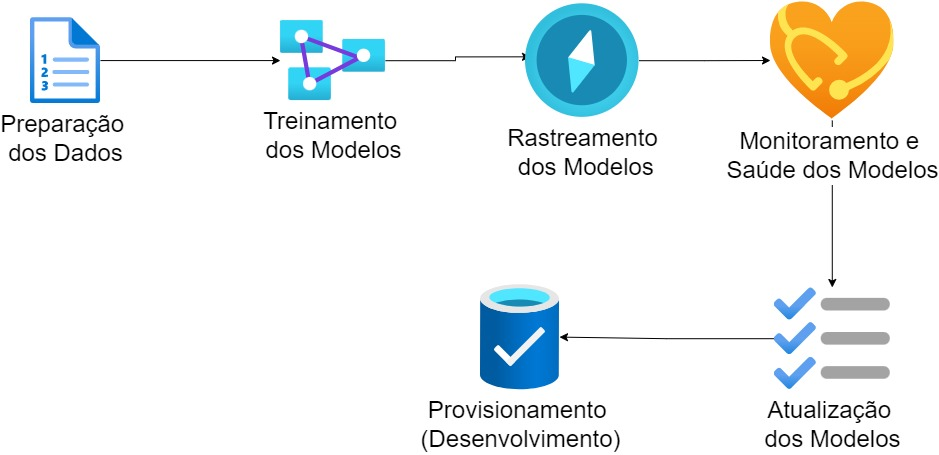

# Pipeline de Desenvolvimento dos Arremessos Kobe Bryant

Neste momento torna-se necessário variar os pipelines de forma que poderemos aproveitar os dados estruturados para avaliar e verificar se os experimentos foram bem feitos e se pode haver uma melhoria nos dados descritos.

Para isso é preciso criar um pipeline para ter um referencial dos modelos criados e guardar os dados dos modelos. Podemos ter os artefatos,métricas e parametros utilizados e testar diferentes modelos para achar o melhor modelo para validar os dados e utilizá-los da melhor maneira.

É possível através deste pipeline separarmos o que será utilizado em desenvolvimento e em seguida colocar em produção os dados utilizados.

Após a validação dos modelos colocados em desenvolvimento, pode ser colocado o modelo em produção para que possa ser utilizado nas APIs selecionadas

## Inicio dos Pipelines 

In [28]:
#!mlflow ui --backend-store-uri sqlite:///mlruns.db

In [6]:
# Para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///../mlruns.db")

experiment_name = 'Projeto Black Mamba'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id

## Pipeline para a Preparação dos Dados Kobe Bryant

In [21]:
# COLOCAR RUN DE LEITURA DE DADOS
# PARAMETROS: top_features,
# METRICS: SHAPE de cada base de dados
# ARTIFACTS: nenhum

with mlflow.start_run(experiment_id=experiment_id, run_name = 'PreparacaoDados'):
    df_kobe = pd.read_csv('../Data/Raw/kobe_dataset.csv',sep=',')
    kobe_target_col = 'shot_made_flag'
    df_kobe_2p = df_kobe[df_kobe['shot_type'] == '2PT Field Goal']
    df_kobe_3p = df_kobe[df_kobe['shot_type'] == '3PT Field Goal']
    df_kobe_2p = df_kobe_2p[['lat','lon','minutes_remaining','period', 'playoffs','shot_distance','shot_made_flag']]
    df_kobe_3p = df_kobe_3p[['lat','lon','minutes_remaining','period', 'playoffs','shot_distance','shot_made_flag']]
    df_kobe_2p = df_kobe_2p.dropna()
    df_kobe_3p = df_kobe_3p.dropna()
    test_size = 0.2
    
    # Separar parte para compor a base de operacao
    xtrain, data_operation, ytrain, ytest = model_selection.train_test_split(df_kobe_2p, 
                                                                            df_kobe_2p[kobe_target_col],
                                                                            test_size=test_size)
    
    data_novelty = df_kobe_3p.copy()
    xtrain[kobe_target_col]      = ytrain
    data_operation[kobe_target_col] = ytest
    
    xtrain.to_parquet('../Data/Processed/data_filtered.parquet')
    data_operation.to_parquet('../Data/Processed/base_8020.parquet')
    data_novelty.to_parquet('../Data/Processed/base_kobe_novidade.parquet')

    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("test_size", test_size)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("data_dev", df_kobe_2p.shape[0])
    mlflow.log_metric("data_operation", data_operation.shape[0])
   
    
mlflow.end_run()

print('== Bases de Dados ==')
print(f'xtrain {xtrain.shape}')
print(f'data_operation {data_operation.shape}')
print(f'Columns: {df_kobe_2p.columns}')

== Bases de Dados ==
xtrain (16228, 7)
data_operation (4057, 7)
Columns: Index(['lat', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'shot_distance', 'shot_made_flag'],
      dtype='object')


In [74]:
df_kobe['shot_type'].value_counts()

2PT Field Goal    24271
3PT Field Goal     6426
Name: shot_type, dtype: int64

## Pipeline para os Treinamentos dos Dados Kobe Bryant

**IMPORTANCIA DAS FERRAMENTAS NO TREINAMENTO**

**Streamlit** - Pode ser utilizado para a criação dos Dashboards com a utilização do treinamento pra verificar de maneira visual as diferenças da base entretanto nesse exemplo não é utilizado

**MLFlow**  - É utilizado para registrar os experimentos e treinamentos da base dos dados além de salvar artefatos, parametros e métricas 

**PyCaret** - Verifica o melhor modelo da base através dos parametros a serem utilizados, gera os artefatos e além das bases treinados

**Scikit-Learn** - É utiliado para calcular as métricas geradas no treinamento

### Pipeline para o Treinamento

In [31]:
# COLOCAR RUN DE TREINAMENTO DE MODELOS
# PARAMETROS: fold_strategy, fold, model_name, registered_model_name, cross_validation
# METRICS: auto sklearn
# ARTIFACTS: plots

with mlflow.start_run(experiment_id=experiment_id, run_name = 'Treinamento'):
    
    models = ['lr','dt']
    probability_threshold = 0.5
    cross_validation = True
    fold_strategy = 'stratifiedkfold',
    fold = 10

    # train/test
    s = pc.setup(data = xtrain, 
                 target = kobe_target_col,
                 test_data = data_operation,
                 silent = True,
                 fold_strategy = 'stratifiedkfold',
                 fold = fold,
                 log_experiment = True, 
                 experiment_name = experiment_name, 
                 log_plots = True,
                 verbose=False
                )
    #bestmodel = pc.create_model(model_name,cross_validation = cross_validation,probability_threshold=probability_threshold)
    add_metric('logloss', 'Log Loss', log_loss, greater_is_better = False)
    bestmodel = pc.compare_models(include = models, sort='f1',n_select=2)
    

    
    # Log do run, e nao do modelo respectivo
    classification_plots = [ 'auc','pr','confusion_matrix',
    #                          'error', 'class_report', 
                            'threshold',
                             'learning','vc','feature',
                           ]
    for plot_type in classification_plots:
        print('=> Aplicando plot ', plot_type)
        try:
            artifact = pc.plot_model(bestmodel[0], scale=10,plot=plot_type, save=True, use_train_data=False)
            mlflow.log_artifact(artifact)
        except:
            print('=> Nao possivel plotar: ', plot_type )
            continue

    pred_holdout = pc.predict_model(bestmodel[0])
    pred_holdout_sec = pc.predict_model(bestmodel[1])
    mlflow.log_metrics({"log loss Arvore":  log_loss(ytest, pred_holdout['Label'].astype(float)),
                       "f1 Arvore": f1_score(ytest, pred_holdout['Label'].astype(float)),
                       })
    
    mlflow.log_metrics({"log loss LR":  log_loss(ytest, pred_holdout_sec['Label']),
                       "f1 LR": f1_score(ytest, pred_holdout_sec['Label'].astype(float)),
                       })
    pc.save_model(bestmodel[0], f'../Data/Modeling/{registered_model_name}') 
    # Carrega novamente o pipeline + bestmodel
    model_pipe = pc.load_model(f'../Data/Modeling/{registered_model_name}')


mlflow.end_run()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss
0,Decision Tree Classifier,0.5349,0.5172,0.5881,0.5097,0.5461,0.0742,0.0750,16.0650


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss
0,Logistic Regression,0.5691,0.5886,0.4896,0.5533,0.5195,0.1316,0.1324,14.8815


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


### Artefatos

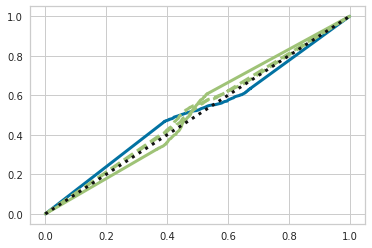

*AUC* -  Verifica a classificação da base de acordo com os dados utilizados


-----------------------------------------------------------------

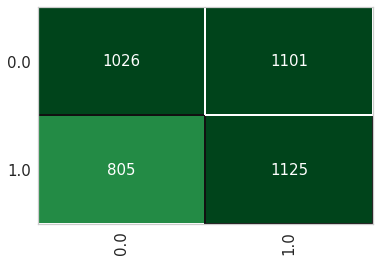

*Matriz de Confusão* - Verifica a matriz com os verdadeiros positivos e negativos  e os falsos negativos e positivos. 
Sendo os números menores condizentes com os valores da matriz de confusão

-----------------------------------------------------------------

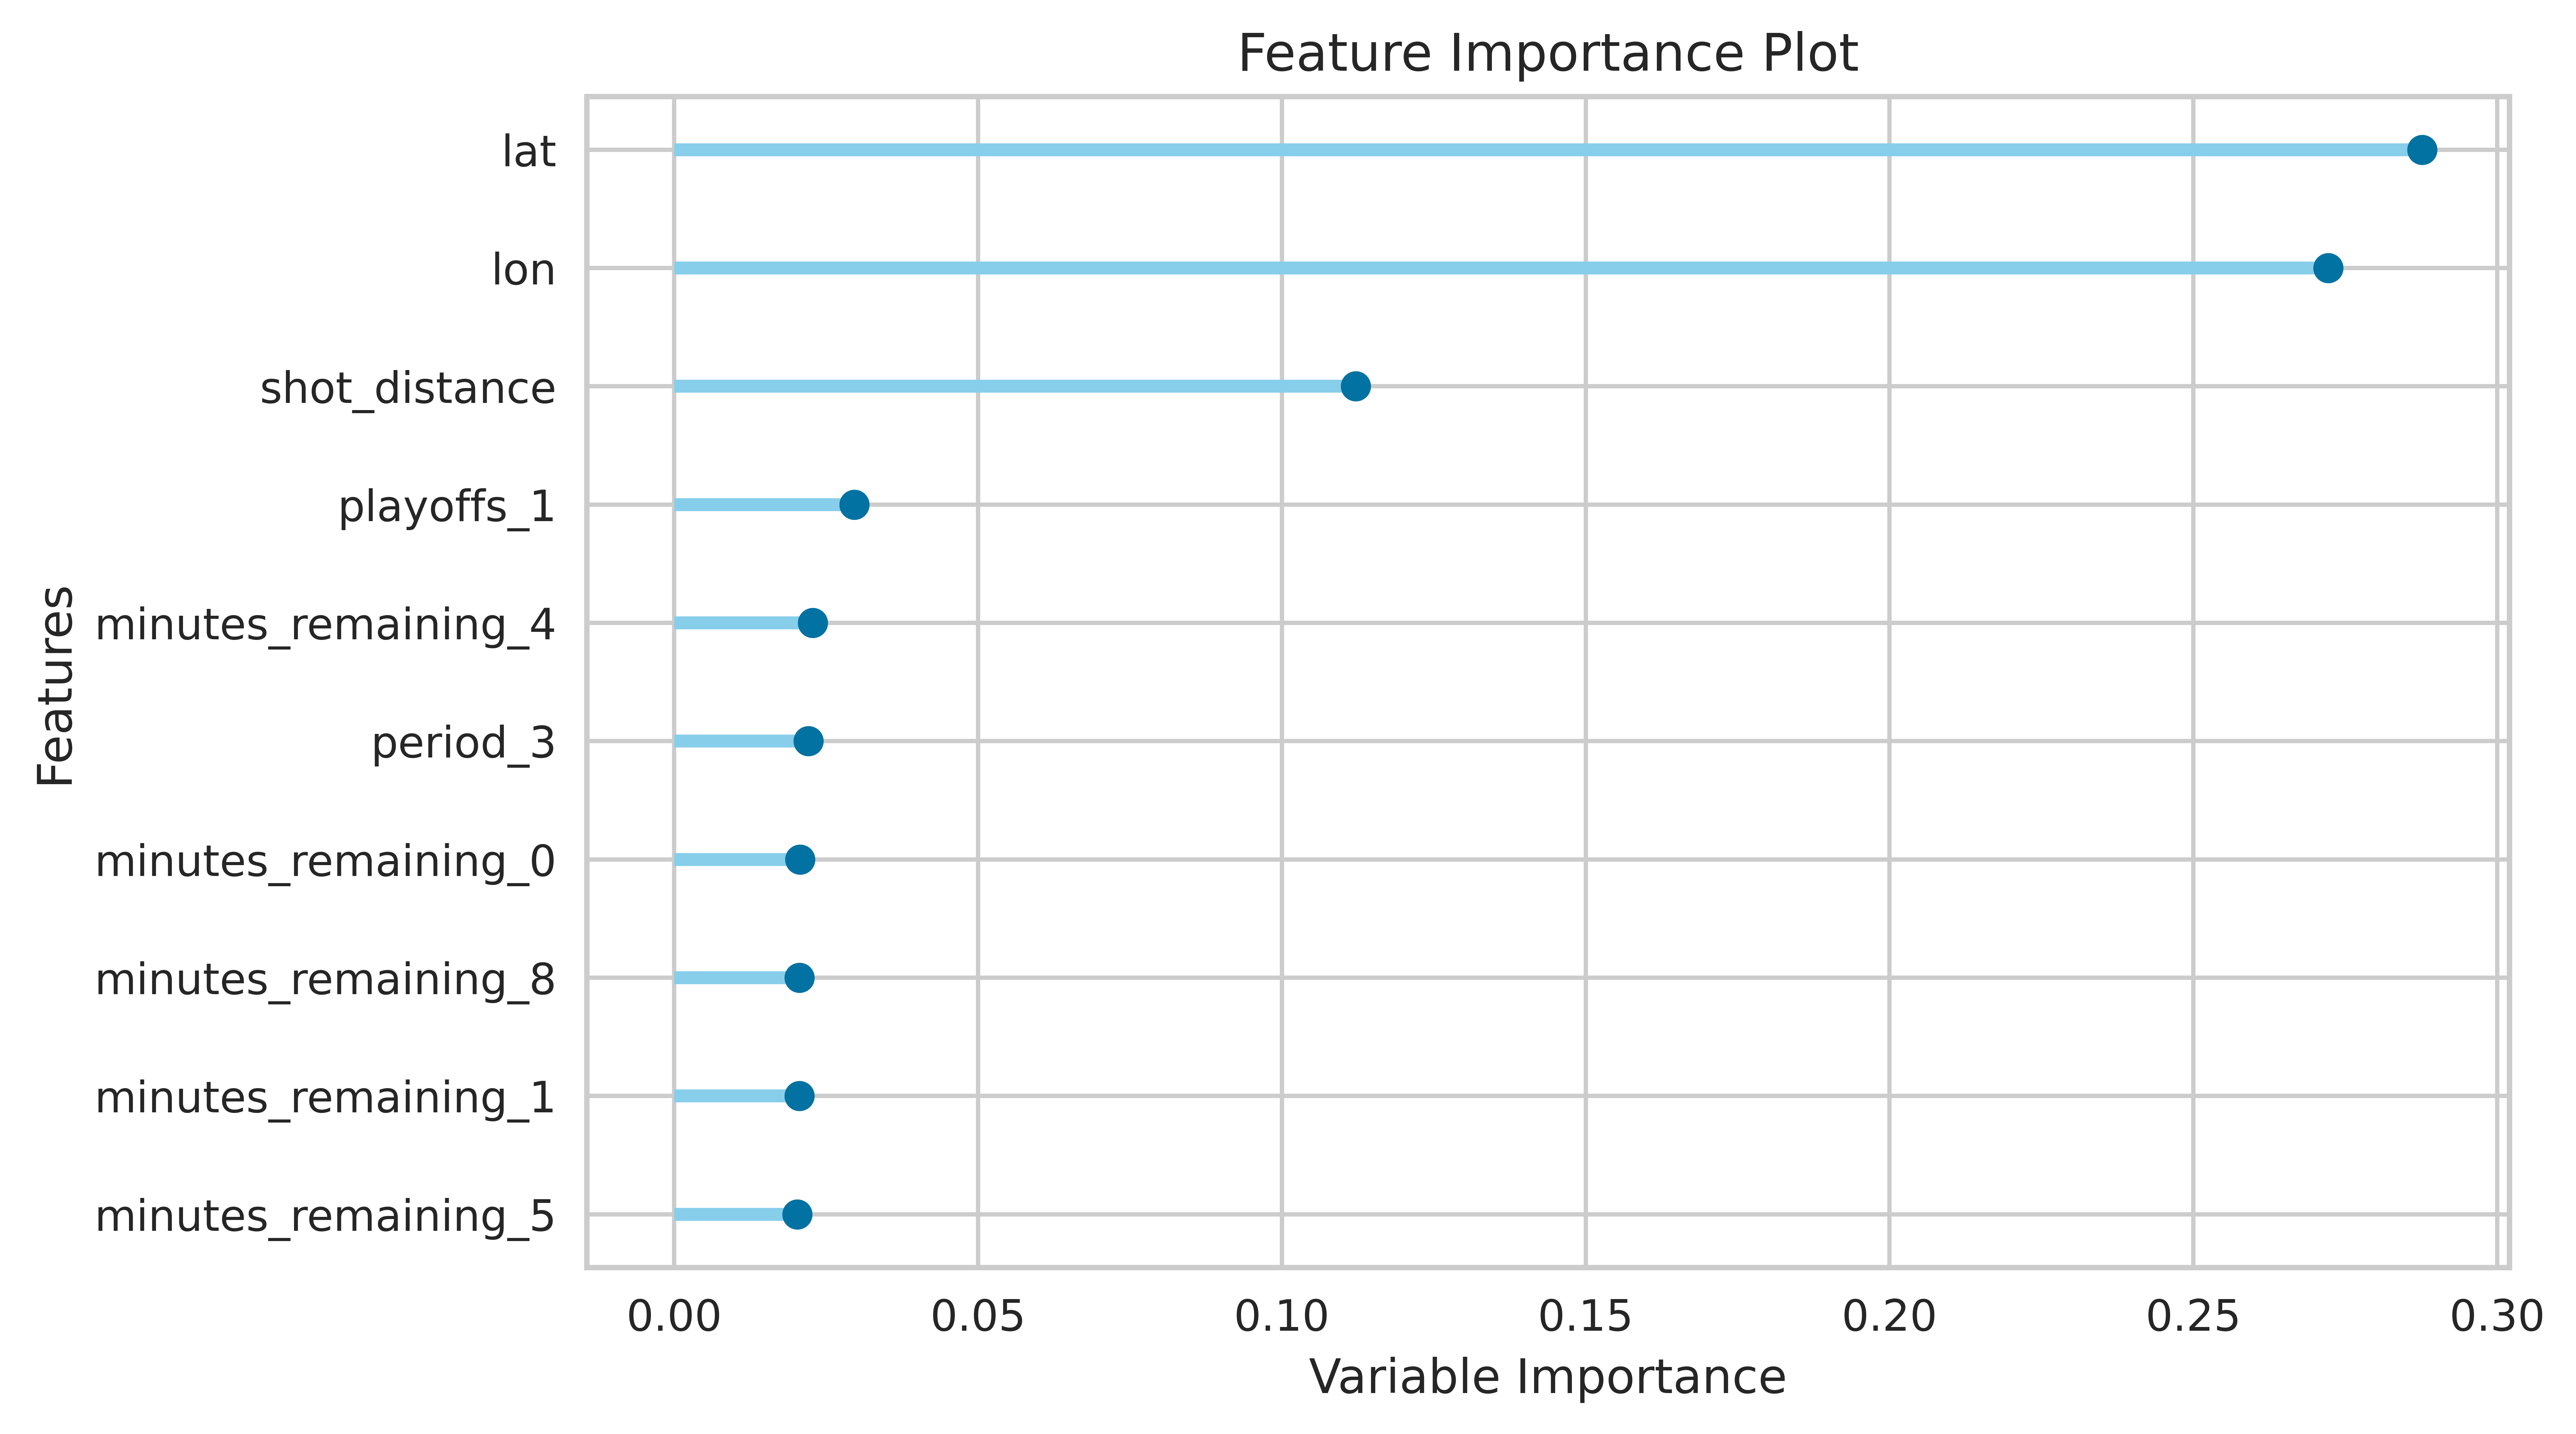

*Variaveis Importantes* -  Fornece a importancia das variaveis para a classificação dos dados

-----------------------------------------------------------------

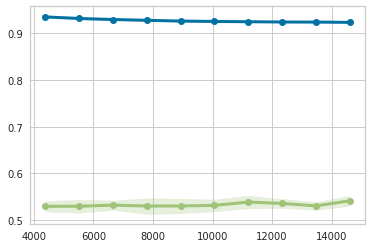

*Curva de Aprendizado* - Conforme o aumento da base se verifica o quanto há de aprendizado desta base no momento que está sendo utilizado

-----------------------------------------------------------------

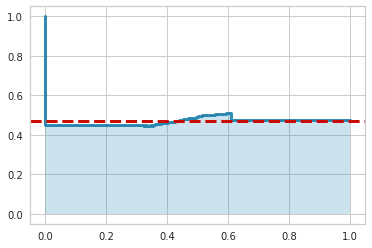

*Curva de precisão-recall* - A curva de precisão serve para detectar a quantidade de itens negativos para a base e os modelos positivos das bases 

-----------------------------------------------------------------

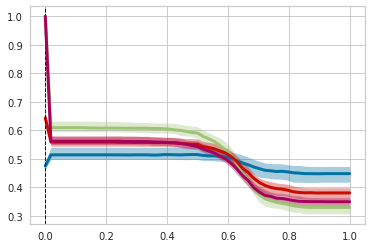

*Threshold* - Verifica com os verdadeiros positivos e negativos  e os falsos negativos e positivos de acordo com o tamanho da base

-----------------------------------------------------------------

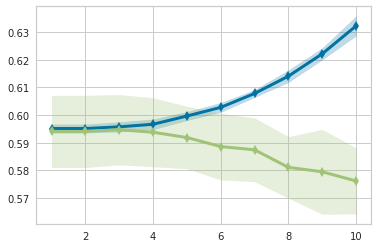


*Curva de Validação* -  A curva de validação é variada de acordo com os k-folds utilizados e é medido de acordo com a porcentagem do aprendizado gerado

## Pipeline para os Rastreamento dos Dados Kobe Bryant

**IMPORTANCIA DAS FERRAMENTAS NO RASTREAMENTO**

**Streamlit** - Não é utilizado nessa etapa

**MLFlow**  - É utilizado para a criação de APIs e a criação dos modelos desenvolvidos para o log, além disso é possivel utilizar através da API para outras bases

**PyCaret** - É utilizado para buscar as configurações dos dados que foram registrados nas etapas anteriores

**Scikit-Learn** - Não é utilizado nessa etapa

#### Servir Dados do Modelo

In [29]:
from mlflow.tracking import MlflowClient
mlflow.set_tracking_uri("sqlite:///../mlruns.db")

registered_model_name = 'modelo_kobe'
model_version = -1 # recuperar a ultima versao
nexamples = 4

In [32]:
# Assinatura do Modelo Inferida pelo MLFlow
model_features = list(df_kobe_2p.drop(kobe_target_col, axis=1).columns)
inf_signature = infer_signature(df_kobe_2p[model_features], model_pipe.predict(df_kobe_2p))
# Exemplo de entrada para o MLmodel
input_example = {x: df_kobe_2p[x].values[:nexamples] for x in model_features}
# Log do pipeline de modelagem do sklearn e registrar como uma nova versao

In [33]:
# Log do pipeline de modelagem do sklearn e registrar como uma nova versao
mlflow.sklearn.log_model(
     sk_model=model_pipe,
     artifact_path="sklearn-model",
     registered_model_name=registered_model_name,
     signature = inf_signature,
     input_example = input_example
 )
# Criacao do cliente do servico MLFlow e atualizacao versao modelo
client = MlflowClient()
if model_version == -1:
    model_version = client.get_latest_versions(registered_model_name)[-1].version
# Registrar o modelo como staging
client.transition_model_version_stage(
     name=registered_model_name,
     version=model_version, # Verificar com usuario qual versao
     stage="Staging"
)
mlflow.end_run()

Registered model 'modelo_kobe' already exists. Creating a new version of this model...
2022/09/20 12:55:05 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: modelo_kobe, version 2
Created version '2' of model 'modelo_kobe'.


In [34]:
import os
os.environ['MLFLOW_TRACKING_URI'] = 'sqlite:///../mlruns.db'
!mlflow models serve -m "models:/modelo_kobe/Staging" --no-conda -p 5002

^C


In [35]:
import requests
host = 'localhost'
port = '5002'
url = f'http://{host}:{port}/invocations'
headers = {'Content-Type': 'application/json'}

http_data = data_operation.drop(kobe_target_col,axis=1).to_json(orient='split')
r = requests.post(url=url, headers=headers, data=http_data)
data_operation.loc[:, 'operation_label'] = pd.read_json(r.text).values[:,0]
data_operation.to_parquet('../Data/Modeling/modelo_kobe_operacao.parquet')

In [36]:
print(metrics.classification_report(data_operation[kobe_target_col], data_operation['operation_label']))

              precision    recall  f1-score   support

         0.0       0.57      0.49      0.52      2127
         1.0       0.51      0.59      0.55      1930

    accuracy                           0.53      4057
   macro avg       0.54      0.54      0.53      4057
weighted avg       0.54      0.53      0.53      4057



#### Consumir o Serviço do Kobe Bryant

Este modelo é  relativamente aderente a base colocada pois varia o valor aumentando o acerto das bases a serem utilizadas

Entretanto as variaveis com o acerto das bolas de 3 pts não possui tanta acurácia por conta da viabilidade da variavel shot_distance pois há um valor muito diferente dos dados utilizados para o treinamento

In [37]:
!curl http://localhost:5002/invocations -X POST -H "Content-Type:application/json; format=pandas-split" --data "{\"columns\":[\"lat\", \"lon\", \"minutes_remaining\", \"period\",\"playoffs\",\"shot_distance\"],\"data\":[[35.9913,-120.3178,8,4,0,7],[33.9703,-118.2908,11,3,0,7]]}"

[1, 1]


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   156  100     6  100   150    119   2988 --:--:-- --:--:-- --:--:--  3183
100   156  100     6  100   150    119   2979 --:--:-- --:--:-- --:--:--  3183


In [38]:
http_data = df_kobe_3p.drop(kobe_target_col,axis=1).to_json(orient='split')
r = requests.post(url=url, headers=headers, data=http_data)

In [39]:
df_kobe_3p.loc[:, 'operation_label'] = pd.read_json(r.text).values[:,0]

print(metrics.classification_report(df_kobe_3p[kobe_target_col], df_kobe_3p['operation_label']))

              precision    recall  f1-score   support

         0.0       0.67      0.49      0.56      3630
         1.0       0.33      0.50      0.40      1782

    accuracy                           0.49      5412
   macro avg       0.50      0.50      0.48      5412
weighted avg       0.55      0.49      0.51      5412



In [40]:
df_kobe_3p[kobe_target_col].value_counts()

0.0    3630
1.0    1782
Name: shot_made_flag, dtype: int64

In [41]:
df_kobe_3p['operation_label'].value_counts()

1    2755
0    2657
Name: operation_label, dtype: int64

In [42]:
import requests
host = 'localhost'
port = '5002'
url = f'http://{host}:{port}/invocations'
headers = {'Content-Type': 'application/json'}

http_data = data_operation.drop(kobe_target_col,axis=1).to_json(orient='split')
r = requests.post(url=url, headers=headers, data=http_data)

In [43]:
!curl http://localhost:5002/invocations -X POST -H "Content-Type:application/json; format=pandas-split" --data "{\"columns\":[\"lat\", \"lon\", \"minutes_remaining\", \"period\",\"playoffs\",\"shot_distance\"],\"data\":[[35.9913,-120.3178,8,4,0,7],[33.9703,-118.2908,11,3,0,7]]}"

[1, 1]


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   156  100     6  100   150     82   2071 --:--:-- --:--:-- --:--:--  2197


In [44]:
http_data = df_kobe_3p.drop(kobe_target_col,axis=1).to_json(orient='split')
r = requests.post(url=url, headers=headers, data=http_data)

In [45]:
df_kobe_3p.loc[:, 'operation_label'] = pd.read_json(r.text).values[:,0]

In [47]:
print(metrics.classification_report(df_kobe_3p[kobe_target_col], df_kobe_3p['operation_label']))

              precision    recall  f1-score   support

         0.0       0.67      0.49      0.56      3630
         1.0       0.33      0.50      0.40      1782

    accuracy                           0.49      5412
   macro avg       0.50      0.50      0.48      5412
weighted avg       0.55      0.49      0.51      5412



In [48]:
df_kobe_3p['operation_label'].value_counts()

1    2755
0    2657
Name: operation_label, dtype: int64

## Pipeline para os Monitoramento dos Dados Kobe Bryant

**IMPORTANCIA DAS FERRAMENTAS NO MONITORAMENTO**

O Monitoramento dos dados é feito caso haja mais de uma acurácia de 50% e é possivel revalidar 
de acordo com uma amostra de 150

**Streamlit** - Não é utilizado no monitoramento dos dados

**MLFlow**  - É utilizado para registrar os experimentos e treinamentos da base dos dados para comparar na aprovação dos dados e recuperar os dados do modelo. Além de gravar os dados colocados no modelo

**PyCaret** - Auxilia para fazer a predição dos modelos resgatados pelo Mlflow além das configurações utilizadas nos modelos.

**Scikit-Learn** - É utilizado para fazer os calculos das métricas dos modelos selecionados

### Aprovação dos Modelos

In [49]:
min_accuracy = 0.5
model_version = -1 # recuperar a ultima versao

In [50]:
# COLOCAR RUN APROVACAO DE MODELO
# PARAMETROS: min_accuracy
# METRICS: new_version, accuracy
# ARTIFACTS: None


with mlflow.start_run(experiment_id=experiment_id, run_name = 'AprovacaoModelo'):
    pred_holdout = pc.predict_model(bestmodel[0])
    acc = metrics.accuracy_score(pred_holdout[kobe_target_col], pred_holdout['Label'])
    if acc > min_precision:
        print(f'=> Aceito o modelo com precisão {acc} (min: {min_accuracy})')
        pred_holdout.to_parquet('../Data/Processed/modelo_kobe_teste.parquet')
        # Assinatura do Modelo Inferida pelo MLFlow
        model_features = list(df_kobe.drop(kobe_target_col, axis=1).columns)
        inf_signature = infer_signature(df_kobe[model_features], model_pipe.predict(df_kobe))
        # Exemplo de entrada para o MLmodel
        input_example = {x: df_kobe[x].values[:nexamples] for x in model_features}
        # Log do pipeline de modelagem do sklearn e registrar como uma nova versao
        mlflow.sklearn.log_model(
            sk_model=model_pipe,
            artifact_path="sklearn-model",
            registered_model_name=registered_model_name,
            signature = inf_signature,
            input_example = input_example
        )
        # Criacao do cliente do servico MLFlow e atualizacao versao modelo
        client = MlflowClient()
        if model_version == -1:
            model_version = client.get_latest_versions(registered_model_name)[-1].version
        # Registrar o modelo como staging
        client.transition_model_version_stage(
            name=registered_model_name,
            version=model_version, # Verificar com usuario qual versao
            stage="Staging"
        )
    else:
        print(f'=> Rejeitado o modelo com precisão {acc} (min: {min_accuracy})')

    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("precisao_minima", min_accuracy)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("new_version", model_version)
    mlflow.log_metric("accuracy", acc)

mlflow.end_run()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss
0,Decision Tree Classifier,0.5349,0.5172,0.5881,0.5097,0.5461,0.0742,0.0750,16.0650


=> Rejeitado o modelo com precisão 0.5348779886615725 (min: 0.5)


### Revalidacao de Amostras para Monitoramento

In [51]:
# COLOCAR RUN REVALIDACAO
# PARAMETROS: min_samples_control
# METRICS: matriz de confusao
# ARTIFACTS:


# Utilizacao da amostra de controle, que teria sido reavaliada por especialistas
min_samples_control = 150

with mlflow.start_run(experiment_id=experiment_id, run_name = 'RevalidacaoOperacao'):

    data_operation = pd.read_parquet('../Data/Modeling/modelo_kobe_operacao.parquet')

    data_control = data_operation.sample(min_samples_control, random_state=SEED)
    data_control.to_parquet('../Data/Processed/modelo_kobe_controle.parquet')

    print('== DADOS DE CONTROLE ==')
    print(metrics.classification_report(data_control[kobe_target_col], data_control['operation_label']))
    
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("min_samples_control", min_samples_control)

    # LOG DE METRICAS GLOBAIS
    cm = metrics.confusion_matrix(data_control[kobe_target_col], data_control['operation_label'])
    specificity = cm[0,0] / cm.sum(axis=1)[0]
    sensibility = cm[1,1] / cm.sum(axis=1)[1]
    precision   = cm[1,1] / cm.sum(axis=0)[1]
    mlflow.log_metric("Especificidade", specificity)
    mlflow.log_metric("Sensibilidade", sensibility)
    mlflow.log_metric("Precisao", precision)

mlflow.end_run()

== DADOS DE CONTROLE ==
              precision    recall  f1-score   support

         0.0       0.51      0.39      0.44        79
         1.0       0.46      0.58      0.51        71

    accuracy                           0.48       150
   macro avg       0.48      0.48      0.48       150
weighted avg       0.49      0.48      0.48       150



### Alarme de Desvio

In [52]:
# reset matplotlib

mpl.rcParams.update(inline_rc)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
mpl.rc('font', **font)
lines = {'linewidth' : 3}
mpl.rc('lines', **lines)

def data_drift_alarm(var_name, dev_data, data_test, data_control):    
    sn.kdeplot(dev_data[var_name], label='Desenvolvimento')
    sn.kdeplot(data_test[var_name], label='Teste')
    sn.kdeplot(data_control[var_name], label='Monitoramento')
    plt.grid()
    plt.legend(loc='best')
    plt.title(f'Distribuição Variável {var_name}')
    plt.ylabel('Distancia')
    plt.xlabel(f'Unidade de {var_name}')
    plt.tight_layout()

### Alarme de Retreinamento

In [53]:
def alarm(data_monitoring, testset, min_eff_alarm):
    cm = metrics.confusion_matrix(data_monitoring[kobe_target_col], data_monitoring['operation_label'])
    specificity_m = cm[0,0] / cm.sum(axis=1)[0]
    sensibility_m = cm[1,1] / cm.sum(axis=1)[1]
    precision_m   = cm[1,1] / cm.sum(axis=0)[1]

    cm = metrics.confusion_matrix(testset[kobe_target_col], testset['Label'])
    specificity_t = cm[0,0] / cm.sum(axis=1)[0]
    sensibility_t = cm[1,1] / cm.sum(axis=1)[1]
    precision_t   = cm[1,1] / cm.sum(axis=0)[1]

    retrain = False
    for name, metric_m, metric_t in zip(['especificidade', 'sensibilidade', 'precisao'],
                                        [specificity_m, sensibility_m, precision_m],
                                        [specificity_t, sensibility_t, precision_t]):
        
        print(f'\t=> {name} de teste {metric_t} e de controle {metric_m}')
        if (metric_t-metric_m)/metric_t > min_eff_alarm:
            print(f'\t=> MODELO OPERANDO FORA DO ESPERADO')
            retrain = True
        else:
            print(f'\t=> MODELO OPERANDO DENTRO DO ESPERADO')
           
        
    return (retrain, [specificity_m, sensibility_m, precision_m],
                                        [specificity_t, sensibility_t, precision_t] ) 

### Monitoramento Base Operação

== ALARME DE RETREINAMENTO - BASE CONTROLE ==
	=> especificidade de teste 0.48660084626234135 e de controle 0.3924050632911392
	=> MODELO OPERANDO FORA DO ESPERADO
	=> sensibilidade de teste 0.5880829015544041 e de controle 0.5774647887323944
	=> MODELO OPERANDO DENTRO DO ESPERADO
	=> precisao de teste 0.50965424337674 e de controle 0.4606741573033708
	=> MODELO OPERANDO DENTRO DO ESPERADO
==> RETREINAMENTO NECESSARIO


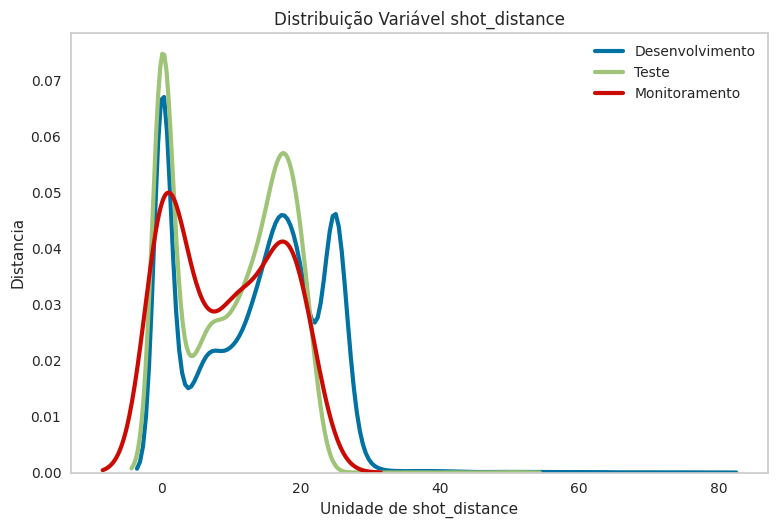

In [54]:
# COLOCAR RUN MONITORAMENTO OPERACAO
# PARAMETROS: min_eff_alarm
# METRICS: metricas avaliadas e de referencia
# ARTIFACTS:

print('== ALARME DE RETREINAMENTO - BASE CONTROLE ==')
# 10% de desvio aceitavel na metrica. Deve ser estimado pelo conjunto de validacao cruzada. 
min_eff_alarm = 0.1 

with mlflow.start_run(experiment_id=experiment_id, run_name = 'MonitoramentoOperacao'):
    data_control = pd.read_parquet('../Data/Processed/modelo_kobe_controle.parquet')
    
    (retrain, [specificity_m, sensibility_m, precision_m],
              [specificity_t, sensibility_t, precision_t] ) = alarm(data_control, pred_holdout, min_eff_alarm)
    if retrain:
        print('==> RETREINAMENTO NECESSARIO')
    else:
        print('==> RETREINAMENTO NAO NECESSARIO')
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("min_eff_alarm", min_eff_alarm)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("Alarme Retreino", float(retrain))
    mlflow.log_metric("Especificidade Controle", specificity_m)
    mlflow.log_metric("Sensibilidade Controle", sensibility_m)
    mlflow.log_metric("Precisao Controle", precision_m)
    mlflow.log_metric("Especificidade Teste", specificity_t)
    mlflow.log_metric("Sensibilidade Teste", sensibility_t)
    mlflow.log_metric("Precisao Teste", precision_t)
    
    # LOG ARTEFATO
    var_name = 'shot_distance' # 'alcohol'
    data_drift_alarm(var_name, df_kobe, pred_holdout, data_control)
    plot_path = f'monitor_datadrift_{var_name}.png'
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)
    

mlflow.end_run()  

## Pipeline para a Atualização dos Dados Kobe Bryant

**IMPORTANCIA DAS FERRAMENTAS NA ATUALIZAÇÃO**

É verificado a quantidade de acurácia do modelo e avaliado os dados do controle e caso tenha o valor necessário não é necessário de acordo com os valores deve ser feito o treinamento novamente

**Streamlit** - Não é utilizado nessa etapa

**MLFlow**  - É utilizado para a criação de APIs e a criação dos modelos desenvolvidos para o log, além disso é possivel utilizar através da API para outras bases

**PyCaret** - Criação de artefatos e grava parametros e metricas 

**Scikit-Learn** - Faz o carregamento do modelo dos dados gravados no Mlflow

### Monitoramento Base de Novidade

== ALARME DE RETREINAMENTO - BASE NOVIDADE ==
	=> especificidade de teste 0.48660084626234135 e de controle 0.7038567493112947
	=> MODELO OPERANDO DENTRO DO ESPERADO
	=> sensibilidade de teste 0.5880829015544041 e de controle 0.31257014590347926
	=> MODELO OPERANDO FORA DO ESPERADO
	=> precisao de teste 0.50965424337674 e de controle 0.34129901960784315
	=> MODELO OPERANDO FORA DO ESPERADO
==> RETREINAMENTO NECESSARIO


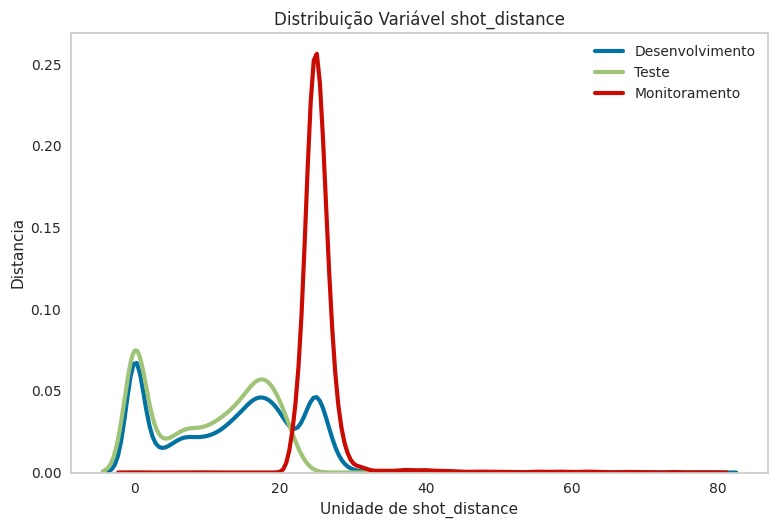

In [60]:
# COLOCAR RUN MONITORAMENTO NOVIDADE
# PARAMETROS: min_eff_alarm
# METRICS: metricas avaliadas e de referencia
# ARTIFACTS:

print('== ALARME DE RETREINAMENTO - BASE NOVIDADE ==')
# 10% de desvio aceitavel na metrica. Deve ser estimado pelo conjunto de validacao cruzada. 
min_eff_alarm = 0.1 

with mlflow.start_run(experiment_id=experiment_id, run_name = 'MonitoramentoNovidade'):

    model_uri = f"models:/modelo_kobe/Staging"
    loaded_model = mlflow.sklearn.load_model(model_uri)
    data_novelty = pd.read_parquet('../Data/Processed/base_kobe_novidade.parquet')
    data_novelty.loc[:, 'operation_label'] = loaded_model.predict(data_novelty)
    
    (retrain, [specificity_m, sensibility_m, precision_m],
              [specificity_t, sensibility_t, precision_t] ) = alarm(data_novelty, pred_holdout, min_eff_alarm)
    if retrain:
        print('==> RETREINAMENTO NECESSARIO')
    else:
        print('==> RETREINAMENTO NAO NECESSARIO')
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("min_eff_alarm", min_eff_alarm)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("Alarme Retreino", float(retrain))
    mlflow.log_metric("Especificidade Controle", specificity_m)
    mlflow.log_metric("Sensibilidade Controle", sensibility_m)
    mlflow.log_metric("Precisao Controle", precision_m)
    mlflow.log_metric("Especificidade Teste", specificity_t)
    mlflow.log_metric("Sensibilidade Teste", sensibility_t)
    mlflow.log_metric("Precisao Teste", precision_t)
    # LOG ARTEFATO
    var_name = 'shot_distance' # 'alcohol'
    data_drift_alarm(var_name, df_kobe, pred_holdout, data_novelty)
    plot_path = f'novidade_datadrift_{var_name}.png'
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)

mlflow.end_run()  

## Pipeline para o Provisionamento dos Dados Kobe Bryant

**IMPORTANCIA DAS FERRAMENTAS NO PROVISIONAMENTO**

**Streamlit** - Não é utilizado nessa etapa

**MLFlow**  - É utilizado para a transição do modelo para a produção

**PyCaret** - Não é utilizado nessa etapa

**Scikit-Learn** - Não é utilizado nessa etapa

In [57]:
# Log do pipeline de modelagem do sklearn e registrar como uma nova versao
mlflow.sklearn.log_model(
     sk_model=model_pipe,
     artifact_path="sklearn-model",
     registered_model_name=registered_model_name,
     signature = inf_signature,
     input_example = input_example
 )
# Criacao do cliente do servico MLFlow e atualizacao versao modelo
client = MlflowClient()
if model_version == -1:
    model_version = 2
# Registrar o modelo como staging
client.transition_model_version_stage(
     name=registered_model_name,
     version=2, # Verificar com usuario qual versao
     stage="Production"
)
mlflow.end_run()

Registered model 'modelo_kobe' already exists. Creating a new version of this model...
2022/09/20 14:34:01 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: modelo_kobe, version 5
Created version '5' of model 'modelo_kobe'.


## Dashboard de Monitoramento

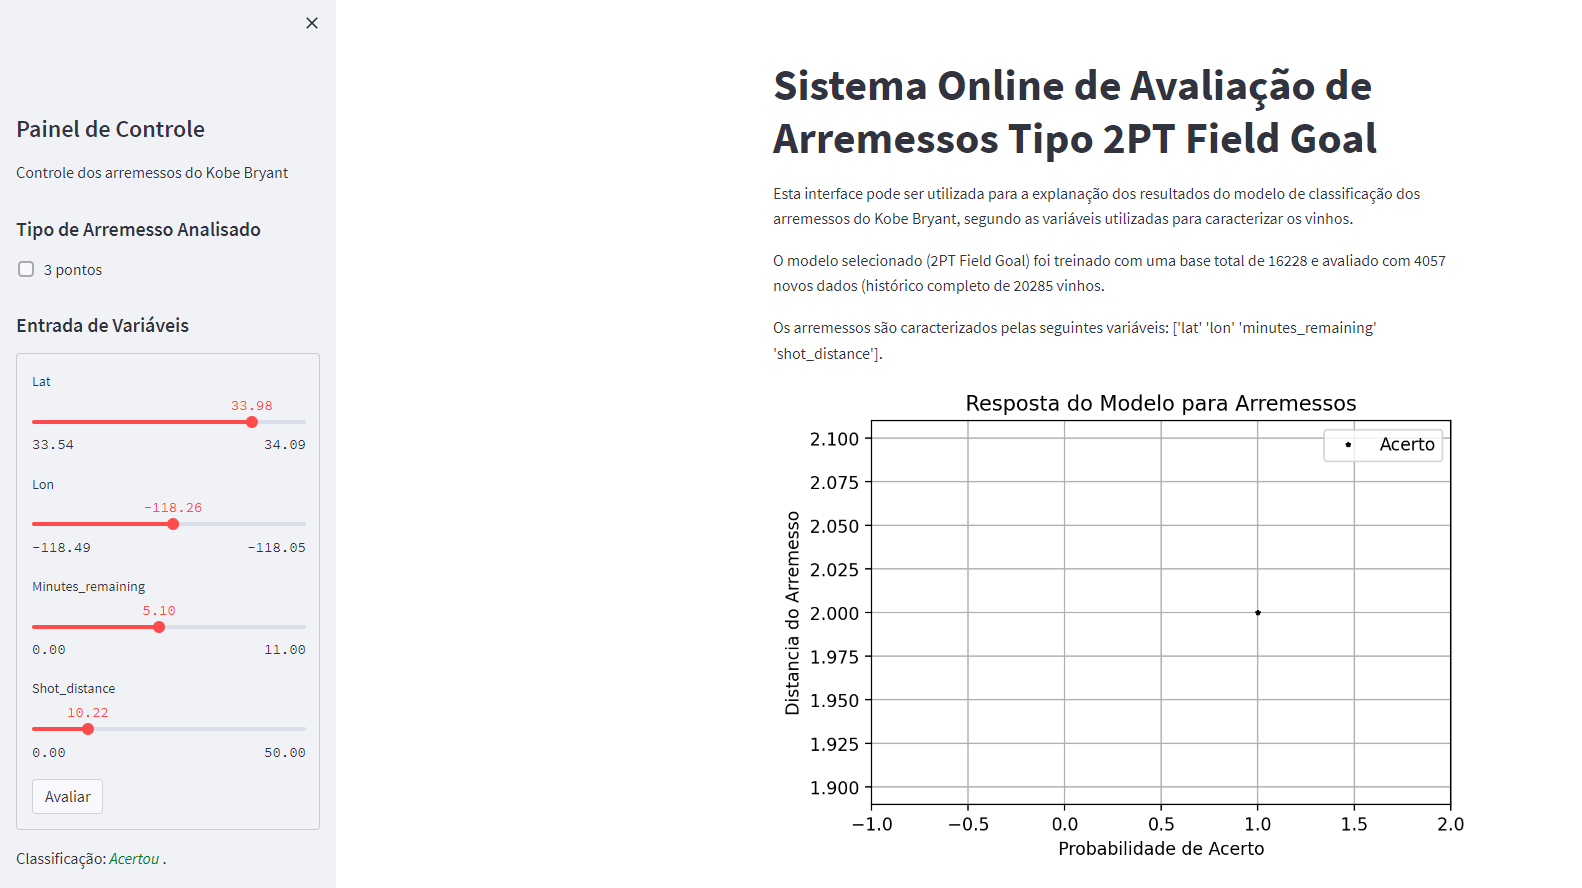